In [1]:
import os
import copy
import time
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from tqdm import tqdm
from torch.utils.data import DataLoader
import torchvision
from torchvision import datasets, transforms, models
import numpy as np
import matplotlib.pyplot as plt

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## minioからデータ取得

In [2]:
import boto3
import zipfile

s3 = boto3.client("s3", endpoint_url="http://13.115.214.145:9000",
                  aws_access_key_id='ubuntu',
                  aws_secret_access_key='hayashifmfm884')
#object_list = s3.list_objects(Bucket='dataset').get("Contents")
dirs = ['train', 'val', 'test']
clss = ['American-shorthair', 'Russian-blue']
for dir_name in dirs:
    for clss_name in clss:
        file = s3.download_file('dataset', dir_name + "/"+ clss_name + ".zip", "./S3/" + dir_name + "/" + clss_name + ".zip")
        with zipfile.ZipFile('S3/' + dir_name + '/' + clss_name + '.zip') as existing_zip:
            existing_zip.extractall('S3/' + dir_name)

## データセット前処理

In [3]:
DATA_DIR = 'S3'
data_transforms = {
    'train': transforms.Compose([
                                transforms.RandomResizedCrop(256, scale=(1,1), ratio=(1,1)),
                                transforms.CenterCrop(256),
                                transforms.ToTensor(), 
                                transforms.Normalize([0.485, 0.456, 0.406],
                                                     [0.229, 0.224, 0.225])
                                ]),
    'val': transforms.Compose([
                                transforms.RandomResizedCrop(256, scale=(1,1), ratio=(1,1)),
                                transforms.CenterCrop(256),
                                transforms.ToTensor(), 
                                transforms.Normalize([0.485, 0.456, 0.406],
                                                     [0.229, 0.224, 0.225])
                                ]),
}

image_datasets = {x: datasets.ImageFolder(os.path.join(DATA_DIR, x), 
                                transform=data_transforms[x]) for x in ['train', 'val']}
dataloaders = {x: DataLoader(image_datasets[x], batch_size=4, 
                             shuffle=True, num_workers=0) for x in ['train', 'val']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

print(dataset_sizes)
print(class_names)
print(dataloaders)

{'train': 619, 'val': 120}
['American-shorthair', 'Russian-blue']
{'train': <torch.utils.data.dataloader.DataLoader object at 0x0000022F512F2400>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x0000022F512F2D68>}


## データ中身確認

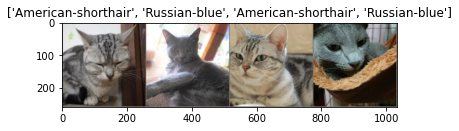

In [4]:
def imshow(inp, title=None):
  "imshow for Tensor"
  inp = inp.numpy().transpose((1,2,0))
  mean = np.array([0.485, 0.456, 0.406])
  std = np.array([0.229, 0.224, 0.225])
  inp = std * inp + mean
  inp = np.clip(inp, 0, 1)
  plt.imshow(inp)
  if title is not None:
    plt.title(title)
  plt.pause(0.001)

inputs, classes = next(iter(dataloaders['train']))

out = torchvision.utils.make_grid(inputs)
imshow(out, title=[class_names[x] for x in classes])

## モデル、損失関数、ハイパーパラメータの定義
モデルとしてpre-trainedなResNet18を使用し、出力次元を2次元にして二値分類を行います。損失関数として交差クロスエントロピー誤差、最適化法としてMomentumSGDを使用します。(転移学習を行う時はAdamより良いらしい）
また、torch.optim.lr_scheduler.StepLRを使用して7 stepごとにlrを1/10します。

In [5]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 4)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to C:\Users\genki/.cache\torch\checkpoints\resnet18-5c106cde.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

モデルの中身を表示してみる。

In [6]:
for x in list(model_ft.children()):
  print(x, '\n')

Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False) 

BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True) 

ReLU(inplace=True) 

MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False) 

Sequential(
  (0): BasicBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (1): BasicBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), 

## 訓練

In [7]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    lossdata = []
    accdata = []
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs-1))
        print('-' * 10)
        
        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train()   # Set model to training mode
            else:
                model.eval()    # Set model to evaluate mode
                
            running_loss = 0.0
            running_corrects = 0
            
            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                # zero the parameter gradients
                optimizer.zero_grad()
                
                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase=='train'):  # 勾配の計算をするかしないか
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                
                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            
            lossdata.append(epoch_loss)
            accdata.append(epoch_acc)
            
            print('{} Loss: {:.4f} Acc: {:4f}'.format(phase, epoch_loss, epoch_acc))
            
            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
        
        print()
    
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))
    
    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, lossdata, accdata


# training
model_ft, lossdata, accdata = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=5)

Epoch 0/4
----------


C:\Users\genki\anaconda3\envs\pytorch36\lib\site-packages\torch\optim\lr_scheduler.py:122: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


train Loss: 0.4159 Acc: 0.822294
val Loss: 0.0112 Acc: 1.000000

Epoch 1/4
----------
train Loss: 0.3028 Acc: 0.893376
val Loss: 0.0746 Acc: 0.966667

Epoch 2/4
----------
train Loss: 0.4073 Acc: 0.861066
val Loss: 0.0384 Acc: 0.991667

Epoch 3/4
----------
train Loss: 0.1905 Acc: 0.938611
val Loss: 0.0803 Acc: 0.983333

Epoch 4/4
----------
train Loss: 0.2548 Acc: 0.927302
val Loss: 0.0063 Acc: 1.000000

Training complete in 16m 0.039379s
Best val Acc: 1.000000


## 損失関数と精度のグラフ

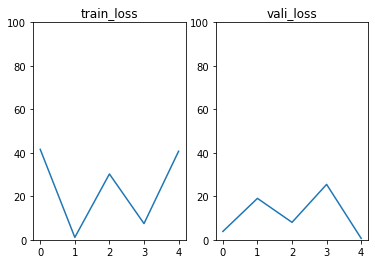

In [8]:
np_losstrain = np.array(lossdata[:5]) * 100
np_lossvali = np.array(lossdata[5:]) * 100

x = list(range(5))

fig = plt.figure()

ax = fig.add_subplot(1, 2, 1, title='train_loss', ylim=(0,100))
ax.plot(x, np_losstrain)
ax = fig.add_subplot(1, 2, 2, title='vali_loss', ylim=(0,100))
ax.plot(x, np_lossvali)
plt.show()

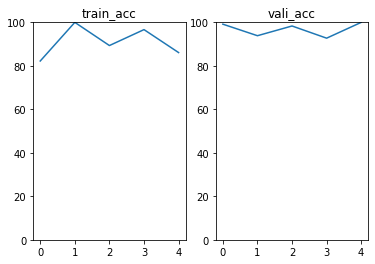

In [9]:
np_traindata = np.array(accdata[:5]) * 100
np_validata = np.array(accdata[5:]) * 100

x = list(range(5))

fig = plt.figure()

ax = fig.add_subplot(1, 2, 1, title='train_acc', ylim=(0,100))
ax.plot(x, np_traindata)
ax = fig.add_subplot(1, 2, 2, title='vali_acc', ylim=(0,100))
ax.plot(x, np_validata)
plt.show()

## validationデータの表示

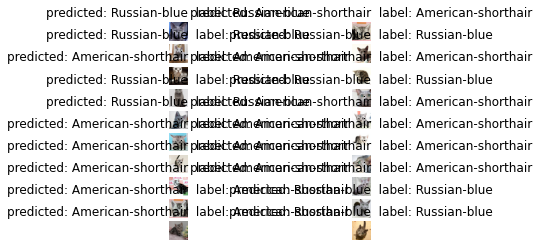

In [10]:
def tensor_to_numpy(inp):
  "imshow for Tensor"
  inp = inp.numpy().transpose((1,2,0))
  mean = np.array([0.485, 0.456, 0.406])
  std = np.array([0.229, 0.224, 0.225])
  inp = std * inp + mean
  inp = np.clip(inp, 0, 1)
  return inp

def visualize_model(model, num_images=20):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = fig.add_subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}  label: {}'
                             .format(class_names[preds[j]], class_names[labels[j]]))
                ax.imshow(tensor_to_numpy(inputs.cpu().data[j]))

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

visualize_model(model_ft)

## テスト

In [13]:
DATA_DIR = 'S3\\test'
transform = transforms.Compose([
                    transforms.RandomResizedCrop(256, scale=(1,1), ratio=(1,1)),
                    transforms.CenterCrop(256),
                    transforms.ToTensor(), 
                    transforms.Normalize([0.485, 0.456, 0.406],
                                        [0.229, 0.224, 0.225])
])

image_test_datasets = datasets.ImageFolder(DATA_DIR, transform=transform)
testloaders = DataLoader(image_test_datasets, batch_size=1, shuffle=True, num_workers=0)

test_dataset_sizes = len(image_test_datasets)
test_class_names = image_test_datasets.classes

print(test_dataset_sizes)
print(test_class_names)

20
['American-shorthair', 'Russian-blue']


predicted: American-shorthair ,  label: American-shorthair


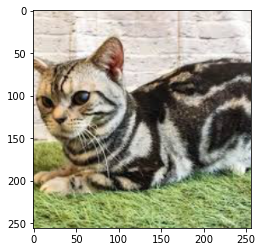

predicted: American-shorthair ,  label: American-shorthair


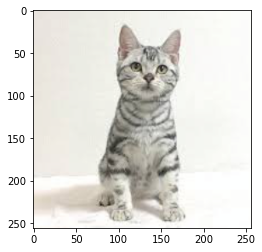

predicted: Russian-blue ,  label: Russian-blue


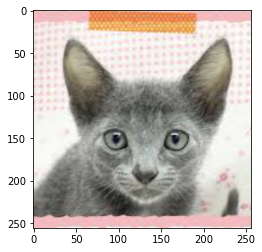

predicted: American-shorthair ,  label: American-shorthair


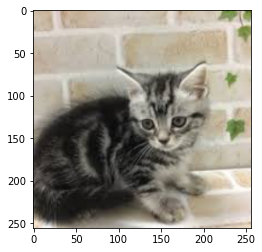

predicted: Russian-blue ,  label: Russian-blue


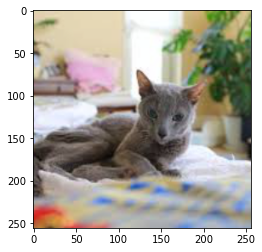

predicted: American-shorthair ,  label: American-shorthair


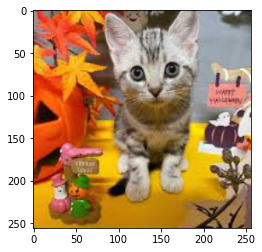

predicted: American-shorthair ,  label: American-shorthair


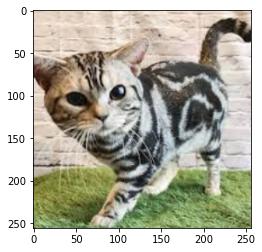

predicted: American-shorthair ,  label: American-shorthair


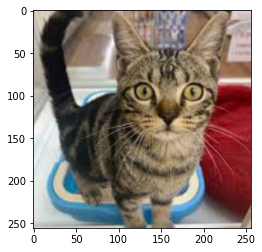

predicted: American-shorthair ,  label: Russian-blue


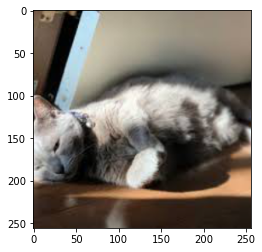

predicted: Russian-blue ,  label: Russian-blue


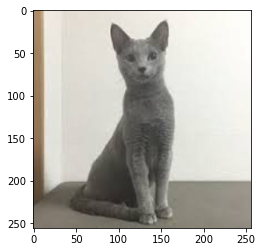

predicted: Russian-blue ,  label: Russian-blue


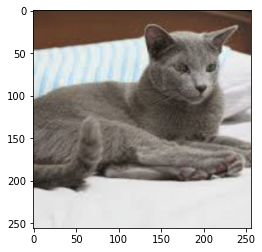

predicted: American-shorthair ,  label: American-shorthair


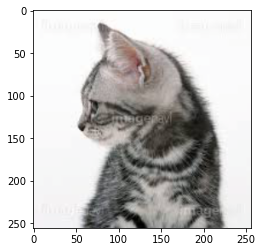

predicted: Russian-blue ,  label: Russian-blue


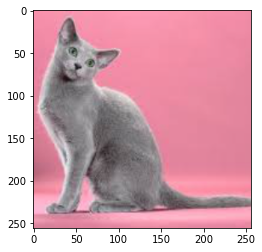

predicted: Russian-blue ,  label: Russian-blue


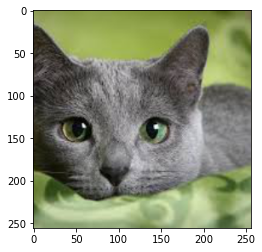

predicted: Russian-blue ,  label: Russian-blue


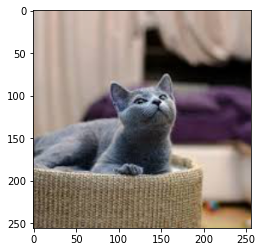

predicted: Russian-blue ,  label: Russian-blue


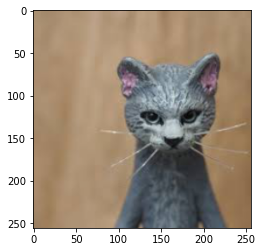

predicted: American-shorthair ,  label: American-shorthair


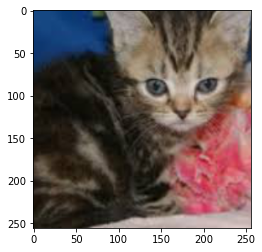

predicted: American-shorthair ,  label: American-shorthair


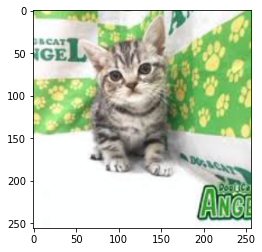

predicted: Russian-blue ,  label: Russian-blue


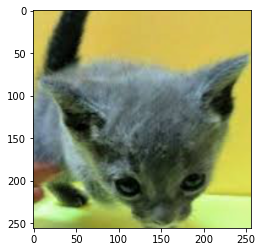

predicted: American-shorthair ,  label: American-shorthair


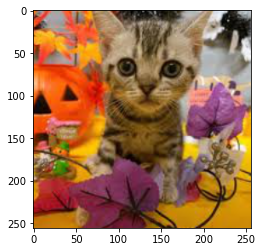

In [14]:
def visualize_model(model, num_images=10):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()
    
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(testloaders):
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            
            print('predicted: {} ,  label: {}'.format(class_names[preds], test_class_names[labels]))
            plt.imshow(tensor_to_numpy(inputs.cpu().data[0]))
            plt.show()
            
                
            if images_so_far == num_images:
                print('ok')
                model.train(mode=was_training)
                return
        model.train(mode=was_training)


visualize_model(model_ft, len(testloaders))